### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score


import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    InputLayer,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Activation,
    Flatten,
    Dense,
    Dropout
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG19, EfficientNetB0
from tensorflow.keras.optimizers import Adam

import os
from PIL import Image

is_gpu = tf.config.list_physical_devices('GPU')[0]
if is_gpu:
    print("GPU available")

import warnings
warnings.filterwarnings('ignore')

C:\Users\topboy\anaconda3\envs\tf_gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


GPU available


### Download Dataset if running on Google Colab

In [2]:
if 'google.colab' in str(get_ipython()):
    print('Downloading cards image classification...\n')
    !mkdir -p data
    !curl -L -o data/cards-image-dataset.zip https://www.kaggle.com/api/v1/datasets/download/gpiosenka/cards-image-datasetclassification
    !unzip -q data/cards-image-dataset.zip -d data
    !rm data/cards-image-dataset.zip
    print('Dataset downloaded and extracted to data directory.')
    print('Download demo image for testing...')
    !mkdir -p uploads
    !curl -L -o "uploads/demo.jpg" https://thumbs.dreamstime.com/z/ten-clubs-card-clipping-path-one-series-images-showing-each-playing-standard-deck-all-have-easy-manipulation-270099775.jpg
    print('Demo image downloaded to uploads directory.')
else:
    print('Not running on Colab')

Not running on Colab


### Load Dataset

In [3]:
data = pd.read_csv('data/cards.csv', delimiter=',')
data

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train
...,...,...,...,...,...
8150,52,valid/two of spades/1.jpg,two of spades,two,valid
8151,52,valid/two of spades/2.jpg,two of spades,two,valid
8152,52,valid/two of spades/3.jpg,two of spades,two,valid
8153,52,valid/two of spades/4.jpg,two of spades,two,valid


### Data Preprocessing & Exploration

In [4]:
print(f"Number of card types: {len(data['card type'].unique())}")
print(f"Number of card types with their suits: {len(data['labels'].unique())}")

Number of card types: 14
Number of card types with their suits: 53


Card Types and their counts:
card type
jack     711
queen    665
ace      642
eight    624
five     622
ten      619
six      616
two      613
four     605
nine     580
seven    580
king     579
three    574
joker    125
Name: count, dtype: int64


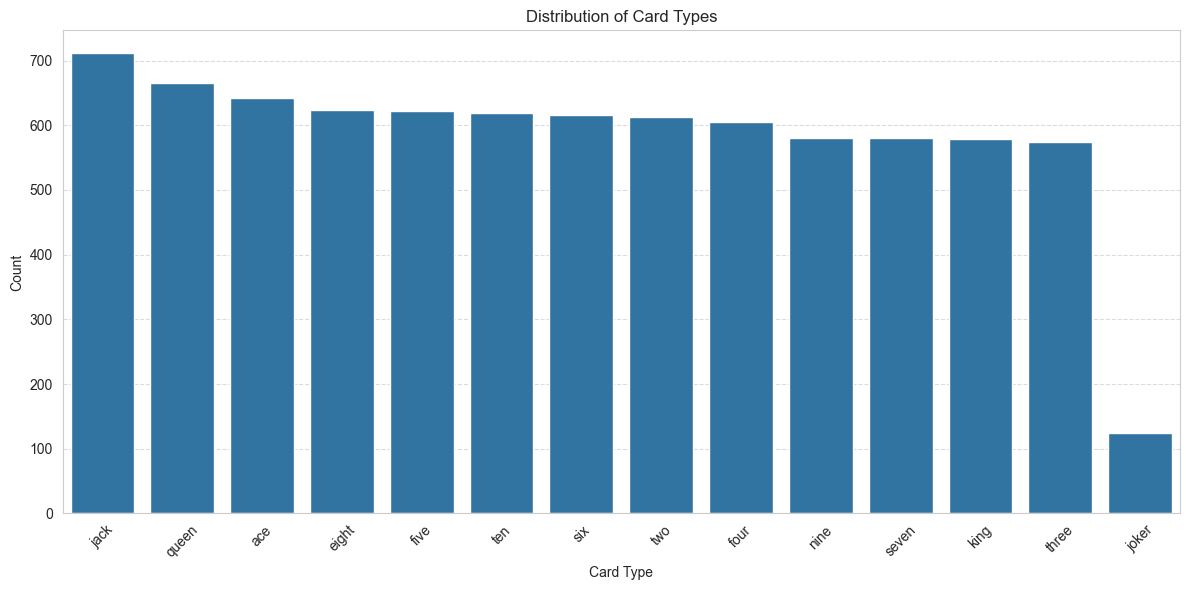

In [5]:
data['card type'] = data['card type'].replace('xxx', 'joker')

# show unique card types and their counts
card_types = data['card type'].value_counts()
print("Card Types and their counts:")
print(card_types)

# plot card types distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='card type', order=card_types.index)
plt.title('Distribution of Card Types')
plt.xlabel('Card Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Custom Models Functions

In [6]:
def create_custom_model_v1(shape, num_classes=14) -> tf.keras.Model:
    custom_model = Sequential(
        [
            InputLayer(shape),
            Conv2D(16, (3, 3), padding='same', activation='relu'),
            MaxPooling2D((2, 2)),
            Flatten(),
            Dense(num_classes, activation="softmax"),
        ],
        name='custom_model_v1'
    )

    custom_model.summary()

    return custom_model


def create_custom_model_v2(shape, num_classes=14) -> tf.keras.Model:
    custom_model = Sequential(
        [
            InputLayer(shape),
            Conv2D(32, (3, 3), padding='same', activation='relu'),
            MaxPooling2D((2, 2)),

            Conv2D(64, (3, 3), padding='same', activation='relu'),
            MaxPooling2D((2, 2)),

            Conv2D(128, (3, 3), padding='same', activation='relu'),
            MaxPooling2D((2, 2)),

            Flatten(),
            Dense(num_classes, activation="softmax"),
        ],
        name='custom_model_v2')

    custom_model.summary()

    return custom_model


def create_custom_model_v3(shape, num_classes=14) -> tf.keras.Model:
    custom_model = Sequential(
        [
            InputLayer(shape),
            Conv2D(32, (3, 3)),

            Activation('relu'),
            MaxPooling2D((2, 2)),

            Conv2D(64, (3, 3)),

            Activation('relu'),
            MaxPooling2D((2, 2)),

            Conv2D(128, (3, 3)),

            Activation('relu'),
            MaxPooling2D((2, 2)),

            Conv2D(256, (3, 3)),

            Activation('relu'),
            MaxPooling2D((2, 2)),

            Flatten(),
            Dense(512, activation="relu"),
            Dropout(0.5),
            Dense(num_classes, activation="softmax"),
        ],
        name='custom_model_v3'
    )

    custom_model.summary()

    return custom_model


def create_pretrained_model_vgg19(shape=(224, 224, 3), num_classes=14) -> tf.keras.Model:
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=shape)
    base_model.trainable = True

    for layer in base_model.layers[:-8]:  # keep early  layers frozen
        layer.trainable = False

    vgg = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation='relu'),
            Dropout(0.2),
            Dense(256, activation='relu'),
            Dropout(0.2),
            Dense(num_classes, activation='softmax')
        ],
        name='vgg19_pretrained_model'
    )

    vgg.summary()

    return vgg


def create_pretrained_model_resnet50(shape=(224, 224, 3), num_classes=14) -> tf.keras.Model:
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=shape)
    base_model.trainable = True
    for layer in base_model.layers[:-15]:  # keep early layers frozen
        layer.trainable = False

    resnet50 = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            Dense(512, activation="relu"),
            Dropout(0.3),
            Dense(256, activation="relu"),
            Dropout(0.3),
            Dense(num_classes, activation="softmax"),
        ],
        name="resnet50_pretrained_model"
    )

    resnet50.summary()

    return resnet50

### Helper Functions

In [7]:
def data_generator(data, batch_size=32, target_size=(224, 224), y_col='card type', use_augmentation=False):
    is_train_set = data['data set'].iloc[0] == 'train'
    if is_train_set and use_augmentation:
        # For training data, apply data augmentation if specified
        datagen = ImageDataGenerator(
            rescale=1. / 255, # Scales pixel values from the range [0, 255] to [0, 1]
            rotation_range=30, # Randomly rotates images by up to 30 degrees (either clockwise or counter-clockwise
            zoom_range=0.2, # Randomly zooms in/out inside images by up to 20%
            horizontal_flip=True, # Randomly flips images horizontally
            fill_mode='nearest', # Use the nearest pixel value to fill in the gap
        )
    else:
        # No augmentation for validation, test data and train data
        datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_dataframe(
        dataframe=data,
        x_col='filepaths',
        y_col=y_col,
        directory='data',
        target_size=target_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=is_train_set,
        seed=42,
    )
    return generator


def plot_images(generator, num_images=8):
    images, labels = next(generator)
    plt.figure(figsize=(6, 6))
    for i in range(num_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.title(list(generator.class_indices.keys())[np.argmax(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()


def get_optimizer(optimizer_name='adam', learning_rate=0.001) -> tf.keras.optimizers.Optimizer:
    params = {
        'class_name': optimizer_name,
        'config': {
            'learning_rate': learning_rate
        }
    }

    return tf.keras.optimizers.get(params)


def get_loss(loss_name='categorical_crossentropy') -> tf.keras.losses.Loss:
    loss = tf.keras.losses.get(loss_name)
    return loss


def prepare_model(model, optimizer='Adam', loss='categorical_crossentropy', learning_rate=0.001,
                  metrics=['accuracy']) -> tf.keras.Model:
    model.compile(
        optimizer=get_optimizer(optimizer, learning_rate),
        loss=get_loss(loss),
        metrics=metrics
    )
    return model


def early_stopping_callback(monitor='val_loss', patience=10) -> tf.keras.callbacks.EarlyStopping:
    return tf.keras.callbacks.EarlyStopping(
        monitor=monitor,
        patience=patience,
        restore_best_weights=True
    )


def model_checkpoint_callback(filepath='models/custom_model.h5',
                              monitor='val_loss') -> tf.keras.callbacks.ModelCheckpoint:
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        monitor=monitor,
        save_best_only=True
    )


def train_model(model, train, validation, epochs=10, batch_size=32, use_early_stopping=None, save_name=None,
                verbose=1) -> tf.keras.callbacks.History:
    callbacks = []

    if use_early_stopping:
        callbacks.append(early_stopping_callback(monitor='val_accuracy', patience=5))

    if save_name:
        if not os.path.exists(f'models/labels_{model.output_shape[1]}'):
            os.makedirs(f'models/labels_{model.output_shape[1]}')

        callbacks.append(model_checkpoint_callback(filepath=f'models/labels_{model.output_shape[1]}/{save_name}.h5',
                                                   monitor='val_accuracy'))

    return model.fit(
        train,
        validation_data=validation,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        steps_per_epoch=len(train),
        validation_steps=len(validation),
        callbacks=callbacks
    )


def predict_model(model, generator, verbose=1) -> np.ndarray:
    return model.predict(generator, verbose=verbose)


def get_classification_report(model, generator) -> str:
    predictions = predict_model(model, generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    print(
        classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys()), zero_division=0))


def get_recall_score(model, generator):
    predictions = predict_model(model, generator, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    return recall_score(y_true, y_pred, average='macro')


def get_f1_score(model, generator):
    predictions = predict_model(model, generator, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    return f1_score(y_true, y_pred, average='macro')


def plot_confusion_matrix(model, generator, verbose=0) -> None:
    predictions = model.predict(generator, verbose=verbose)
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    cm = confusion_matrix(y_true, y_pred)
    class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
        best_val_acc = max(history.history['val_accuracy'])
        best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  # +1 because epochs start at 1
        plt.plot(best_epoch, best_val_acc, 'ro')  # Highlight best validation accuracy
    plt.title('Training and Validation Accuracy')
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def print_model_performance(model, history, valid_generator, test_generator) -> None:
    best_val_accuracy = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_accuracy)
    print(f"Saved at Epoch: {best_epoch + 1}")

    val_loss = history.history['val_loss'][best_epoch]
    val_accuracy = history.history['val_accuracy'][best_epoch]
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)

    recall = get_recall_score(model, test_generator)
    f1 = get_f1_score(model, test_generator)

    print(f"Validation Loss: {round(val_loss, 2)}")
    print(f"Validation Accuracy: {round(val_accuracy * 100, 2)}%")
    print(f"Test Loss: {round(test_loss, 2)}")
    print(f"Test Accuracy: {round(test_accuracy * 100, 2)}%")
    print(f"Macro Recall: {round(recall * 100, 2)}%")
    print(f"Macro F1: {round(f1 * 100, 2)}%")


def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


def get_predicted_label(model, path):
    img_array = load_and_preprocess_image(path)
    predictions = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(predictions, axis=1)[0]
    class_labels = list(test_generator.class_indices.keys())
    return class_labels[predicted_class]


def display_prediction(model, path):
    predicted_label = get_predicted_label(model, path)
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_label}")
    plt.show()
    plt.close()


### Generate Data without augmentation

In [8]:
y_col = 'card type' # 'labels' for all cards & 'card type' for suits
train_generator = data_generator(data[data['data set'] == 'train'], y_col=y_col, use_augmentation=False)
valid_generator = data_generator(data[data['data set'] == 'valid'], y_col=y_col, use_augmentation=False) # use_augmentation is always false
test_generator = data_generator(data[data['data set'] == 'test'], y_col=y_col, use_augmentation=False) # use_augmentation is always false

Found 7624 validated image filenames belonging to 14 classes.
Found 265 validated image filenames belonging to 14 classes.
Found 265 validated image filenames belonging to 14 classes.


In [9]:
test_generator.class_indices

{'ace': 0,
 'eight': 1,
 'five': 2,
 'four': 3,
 'jack': 4,
 'joker': 5,
 'king': 6,
 'nine': 7,
 'queen': 8,
 'seven': 9,
 'six': 10,
 'ten': 11,
 'three': 12,
 'two': 13}

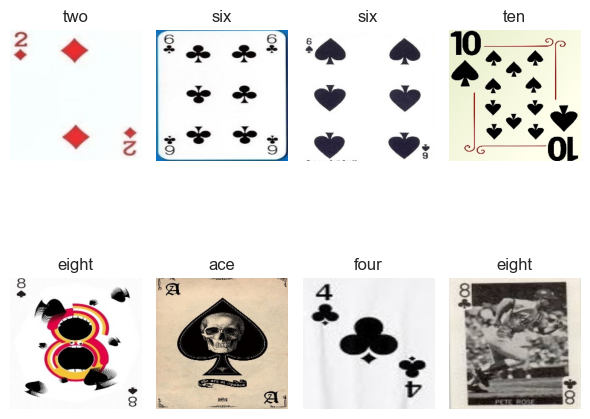

In [10]:
plot_images(train_generator, num_images=8)

### Custom Model v1

In [11]:
model_shape = 'shape' if tf.__version__ >= '2.10.1' else 'input_shape'
print("TensorFlow version:", tf.__version__)

input_args = {
    model_shape: (224, 224, 3)
}

TensorFlow version: 2.10.1


In [12]:
model = create_custom_model_v1(**input_args, num_classes=len(train_generator.class_indices))
model = prepare_model(model, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.0003, metrics=['accuracy'])

history = train_model(model, train_generator, valid_generator, epochs=20, batch_size=32, use_early_stopping = True, save_name=model.name, verbose=1)

Model: "custom_model_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 14)                2809870   
                                                                 
Total params: 2,810,318
Trainable params: 2,810,318
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
239/239 [==============================] - 8s 23ms/step - loss: 2.6932 - accuracy: 0.4325 - val_

In [13]:
get_classification_report(model, test_generator)

9/9 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

         ace       0.83      1.00      0.91        20
       eight       0.61      0.85      0.71        20
        five       0.70      0.80      0.74        20
        four       0.83      0.75      0.79        20
        jack       0.89      0.85      0.87        20
       joker       1.00      1.00      1.00         5
        king       0.79      0.95      0.86        20
        nine       1.00      0.65      0.79        20
       queen       0.89      0.80      0.84        20
       seven       0.94      0.80      0.86        20
         six       0.65      0.75      0.70        20
         ten       0.84      0.80      0.82        20
       three       0.77      0.85      0.81        20
         two       0.83      0.50      0.62        20

    accuracy                           0.80       265
   macro avg       0.83      0.81      0.81       265
weighted avg       0.82     

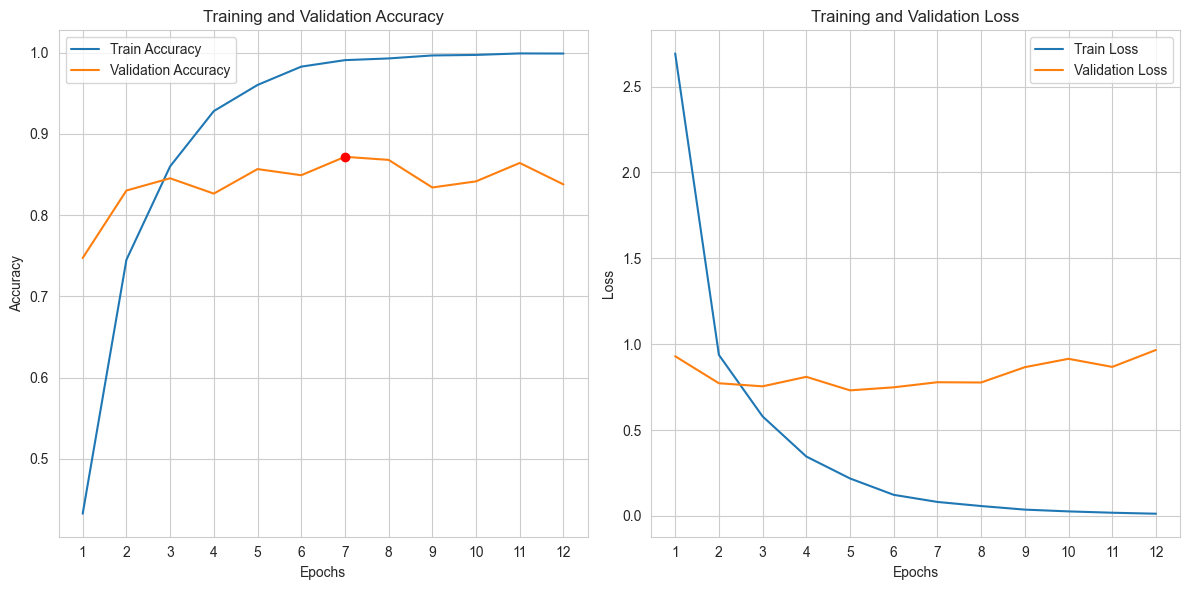

In [14]:
plot_training_history(history)

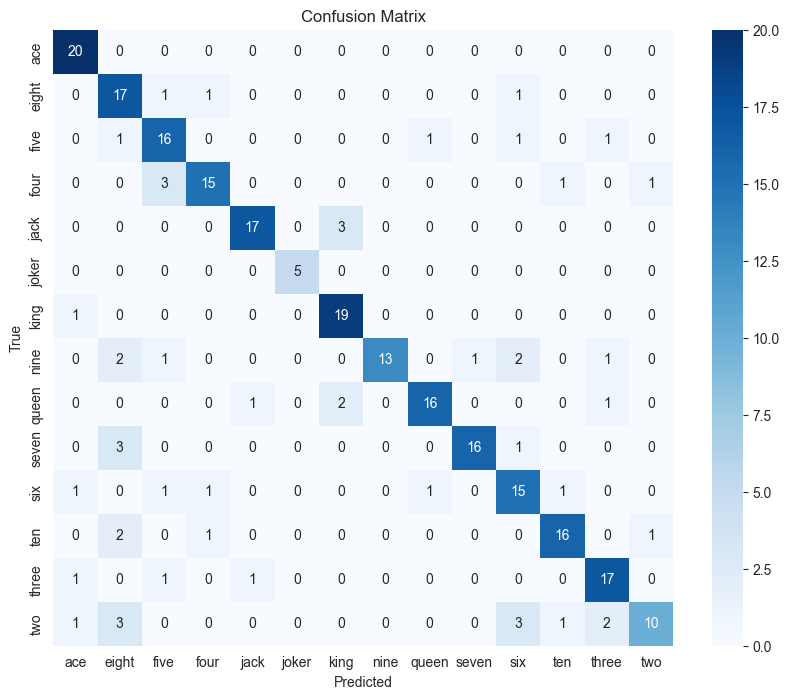

In [15]:
plot_confusion_matrix(model, test_generator)

In [16]:
print('Model Performance Evaluation:')
print_model_performance(model, history, valid_generator, test_generator)

Model Performance Evaluation:
Saved at Epoch: 7
Validation Loss: 0.78
Validation Accuracy: 87.17%
Test Loss: 0.82
Test Accuracy: 80.0%
Macro Recall: 81.07%
Macro F1: 80.96%


Displaying prediction for a sample image...


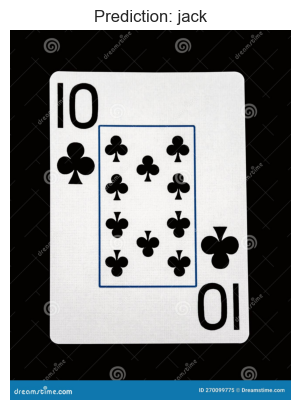

In [17]:
image_path = 'uploads/demo.jpg'
print('Displaying prediction for a sample image...')
display_prediction(model, image_path)

### Custom Model v2

In [18]:
model = create_custom_model_v2(**input_args, num_classes=len(train_generator.class_indices))
model = prepare_model(model, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.0003, metrics=['accuracy'])

history = train_model(model, train_generator, valid_generator, epochs=20, batch_size=32, use_early_stopping = True, save_name=model.name, verbose=1)

Model: "custom_model_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 28, 28, 128)  

In [19]:
get_classification_report(model, test_generator)

9/9 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

         ace       0.90      0.95      0.93        20
       eight       0.64      0.80      0.71        20
        five       1.00      0.80      0.89        20
        four       0.94      0.85      0.89        20
        jack       0.86      0.95      0.90        20
       joker       1.00      0.20      0.33         5
        king       0.87      1.00      0.93        20
        nine       0.80      0.80      0.80        20
       queen       1.00      1.00      1.00        20
       seven       0.74      1.00      0.85        20
         six       0.94      0.75      0.83        20
         ten       0.75      0.90      0.82        20
       three       0.94      0.85      0.89        20
         two       1.00      0.70      0.82        20

    accuracy                           0.86       265
   macro avg       0.89      0.82      0.83       265
weighted avg       0.88     

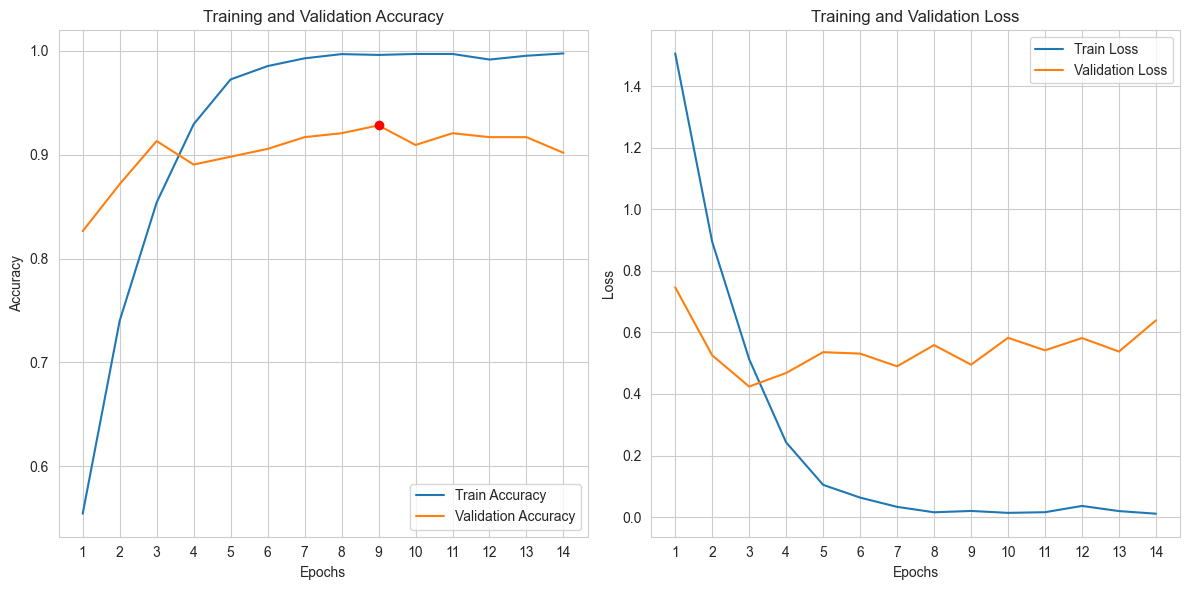

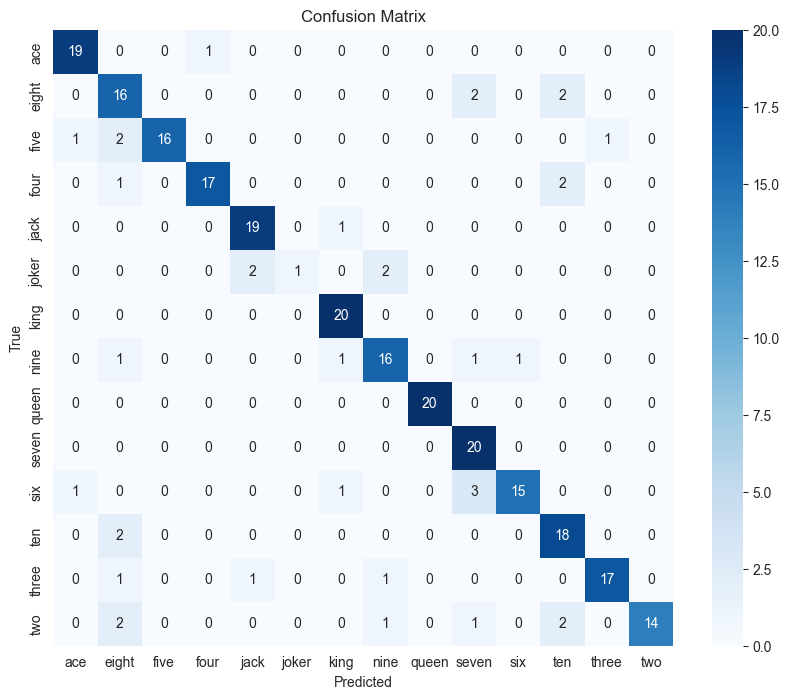

In [20]:
plot_training_history(history)
plot_confusion_matrix(model, test_generator)

In [21]:
print('Model Performance Evaluation:')
print_model_performance(model, history, valid_generator, test_generator)

Model Performance Evaluation:
Saved at Epoch: 9
Validation Loss: 0.5
Validation Accuracy: 92.83%
Test Loss: 0.86
Test Accuracy: 86.04%
Macro Recall: 82.5%
Macro F1: 82.93%


Displaying prediction for a sample image...


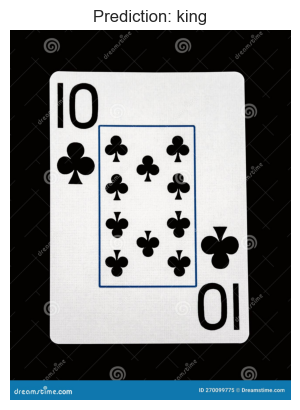

In [22]:
image_path = 'uploads/demo.jpg'
print('Displaying prediction for a sample image...')
display_prediction(model, image_path)

---

### Custom Model v3

In [29]:
model = create_custom_model_v3(**input_args, num_classes=len(train_generator.class_indices))
model = prepare_model(model, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.001,
                      metrics=['accuracy'])

history = train_model(model, train_generator, valid_generator, epochs=30, batch_size=16, use_early_stopping=True,
                      save_name=model.name, verbose=1)

Model: "custom_model_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 activation_9 (Activation)   (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                              

In [30]:
get_classification_report(model, test_generator)

9/9 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

         ace       0.95      1.00      0.98        20
       eight       0.86      0.95      0.90        20
        five       0.94      0.80      0.86        20
        four       0.95      0.95      0.95        20
        jack       0.90      0.90      0.90        20
       joker       1.00      0.80      0.89         5
        king       0.91      1.00      0.95        20
        nine       0.81      0.85      0.83        20
       queen       0.90      0.95      0.93        20
       seven       1.00      1.00      1.00        20
         six       0.78      0.90      0.84        20
         ten       0.85      0.85      0.85        20
       three       1.00      0.90      0.95        20
         two       1.00      0.80      0.89        20

    accuracy                           0.91       265
   macro avg       0.92      0.90      0.91       265
weighted avg       0.91     

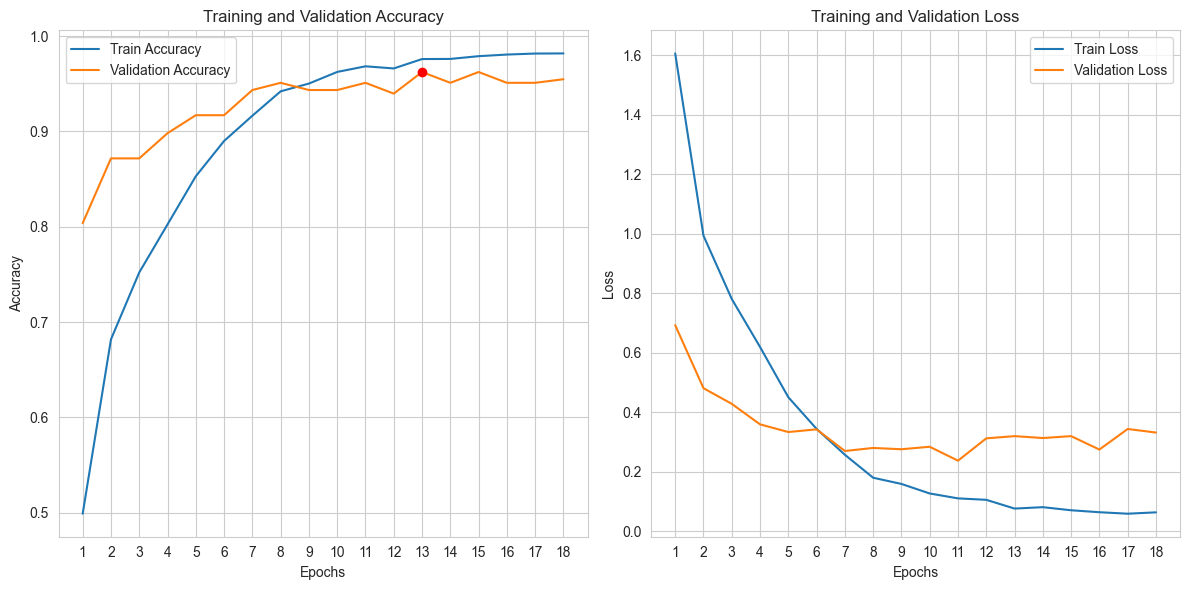

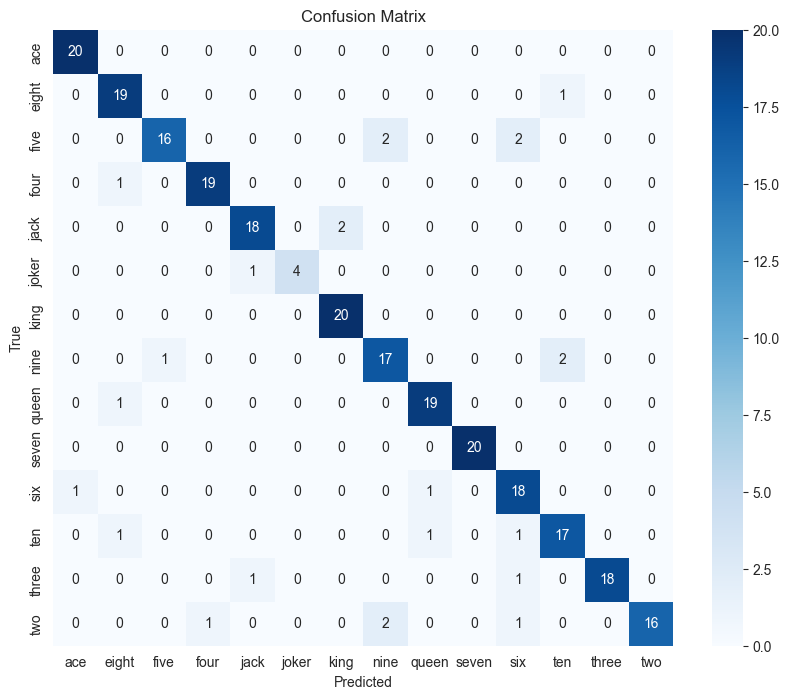

In [31]:
plot_training_history(history)
plot_confusion_matrix(model, test_generator)

In [32]:
print('Model Performance Evaluation:')
print_model_performance(model, history, valid_generator, test_generator)

Model Performance Evaluation:
Saved at Epoch: 13
Validation Loss: 0.32
Validation Accuracy: 96.23%
Test Loss: 0.42
Test Accuracy: 90.94%
Macro Recall: 90.36%
Macro F1: 90.83%


Displaying prediction for a sample image...


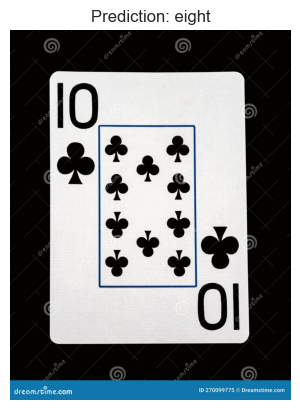

In [34]:
image_path = 'uploads/demo.jpg'
print('Displaying prediction for a sample image...')
display_prediction(model, image_path)

### VGG 19

In [35]:
vgg19_model = create_pretrained_model_vgg19(shape=(224, 224, 3), num_classes=len(train_generator.class_indices))

vgg19_model = prepare_model(vgg19_model, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.0003, metrics=['accuracy'])
history = train_model(vgg19_model, train_generator, valid_generator, epochs=20, batch_size=32, use_early_stopping=True, save_name=vgg19_model.name, verbose=1)

Model: "vgg19_pretrained_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                            

In [36]:
get_classification_report(vgg19_model, test_generator)

9/9 [==============================] - 1s 91ms/step
              precision    recall  f1-score   support

         ace       1.00      1.00      1.00        20
       eight       0.87      1.00      0.93        20
        five       0.90      0.95      0.93        20
        four       1.00      1.00      1.00        20
        jack       0.87      1.00      0.93        20
       joker       0.67      0.40      0.50         5
        king       1.00      1.00      1.00        20
        nine       1.00      0.90      0.95        20
       queen       1.00      0.95      0.97        20
       seven       0.95      1.00      0.98        20
         six       0.95      0.90      0.92        20
         ten       0.95      0.95      0.95        20
       three       1.00      0.95      0.97        20
         two       1.00      0.95      0.97        20

    accuracy                           0.95       265
   macro avg       0.94      0.92      0.93       265
weighted avg       0.96     

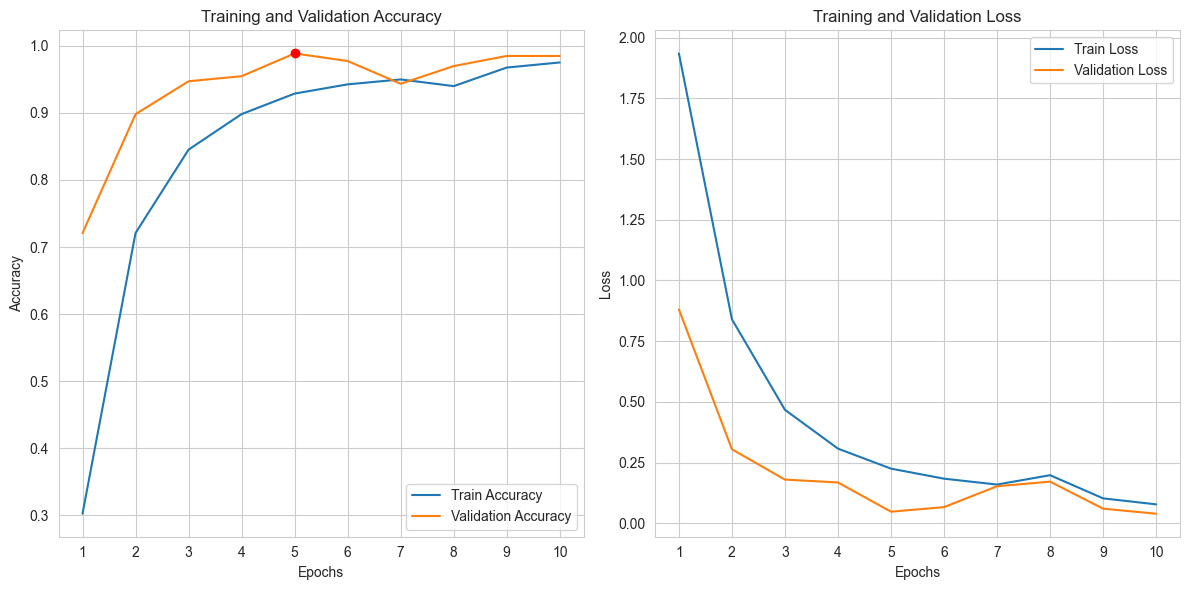

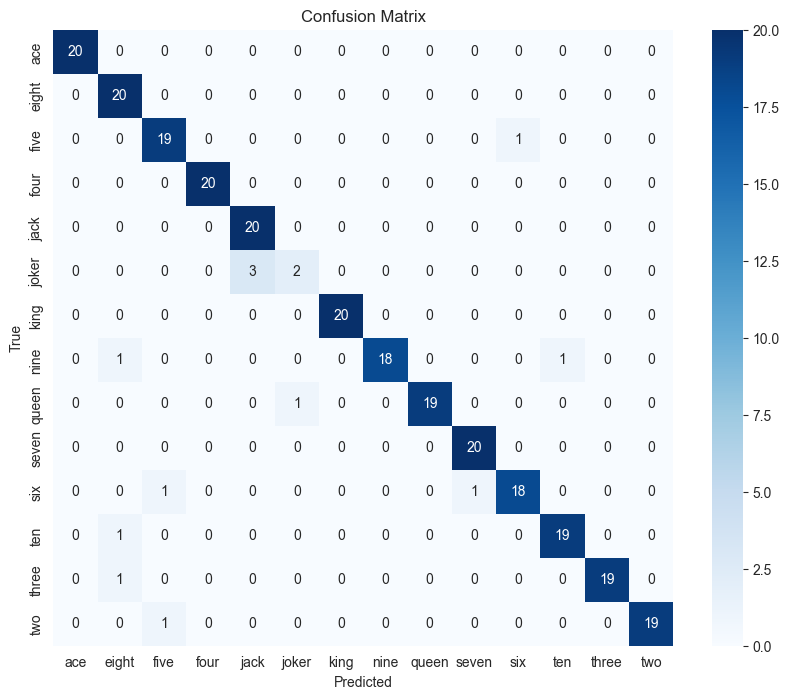

In [37]:
plot_training_history(history)
plot_confusion_matrix(vgg19_model, test_generator)

In [38]:
print('Model Performance Evaluation:')
print_model_performance(vgg19_model, history, valid_generator, test_generator)

Model Performance Evaluation:
Saved at Epoch: 5
Validation Loss: 0.05
Validation Accuracy: 98.87%
Test Loss: 0.14
Test Accuracy: 95.47%
Macro Recall: 92.5%
Macro F1: 92.9%


Displaying prediction for a sample image...


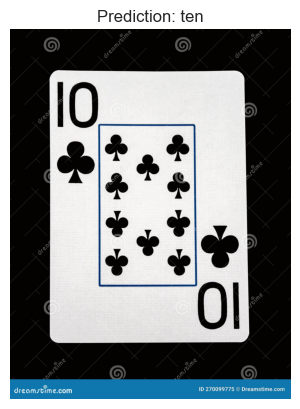

In [39]:
image_path = 'uploads/demo.jpg'
print('Displaying prediction for a sample image...')
display_prediction(vgg19_model, image_path)

### ResNet50

In [40]:
resnet50_model = create_pretrained_model_resnet50(shape=(224, 224, 3), num_classes=len(train_generator.class_indices))
resnet50_model = prepare_model(resnet50_model, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.0003, metrics=['accuracy'])
history = train_model(resnet50_model, train_generator, valid_generator, epochs=30, batch_size=16, use_early_stopping=True, save_name=resnet50_model.name, verbose=1)

Model: "resnet50_pretrained_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_11 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                         

In [41]:
get_classification_report(resnet50_model, test_generator)

9/9 [==============================] - 1s 55ms/step
              precision    recall  f1-score   support

         ace       0.91      1.00      0.95        20
       eight       0.71      1.00      0.83        20
        five       1.00      0.60      0.75        20
        four       1.00      0.75      0.86        20
        jack       0.78      0.90      0.84        20
       joker       1.00      1.00      1.00         5
        king       0.94      0.85      0.89        20
        nine       0.76      0.65      0.70        20
       queen       0.86      0.95      0.90        20
       seven       0.78      0.90      0.84        20
         six       0.82      0.70      0.76        20
         ten       0.81      0.85      0.83        20
       three       0.82      0.90      0.86        20
         two       0.85      0.85      0.85        20

    accuracy                           0.84       265
   macro avg       0.86      0.85      0.85       265
weighted avg       0.85     

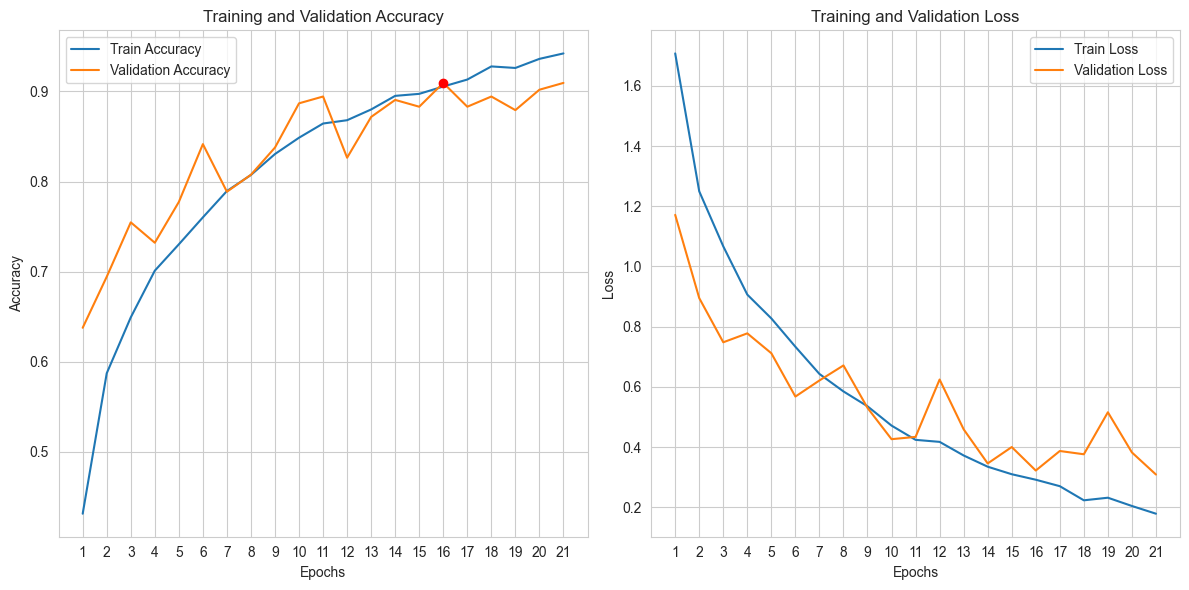

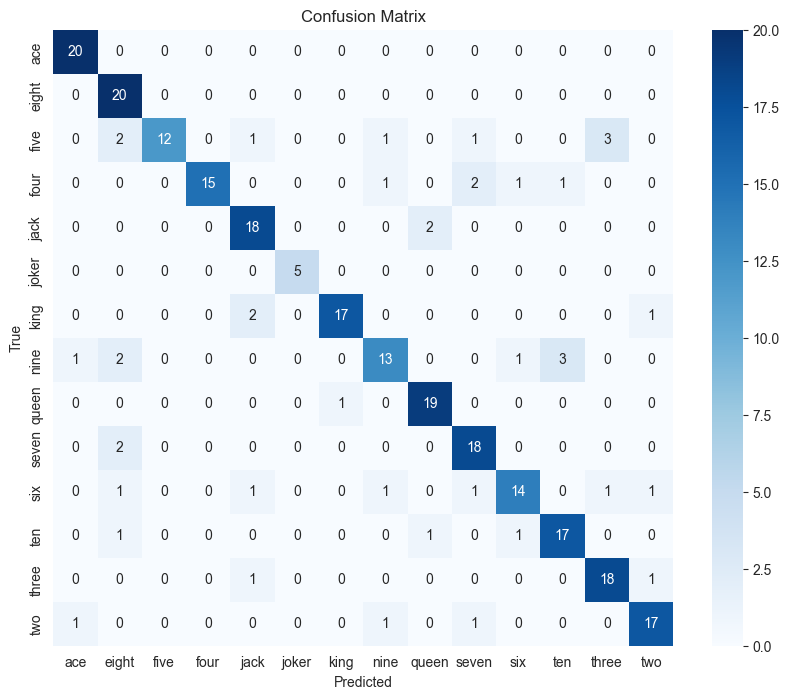

In [42]:
plot_training_history(history)
plot_confusion_matrix(resnet50_model, test_generator)

In [43]:
print('Model Performance Evaluation:')
print_model_performance(resnet50_model, history, valid_generator, test_generator)

Model Performance Evaluation:
Saved at Epoch: 16
Validation Loss: 0.32
Validation Accuracy: 90.94%
Test Loss: 0.77
Test Accuracy: 84.15%
Macro Recall: 85.0%
Macro F1: 84.73%


Displaying prediction for a sample image...


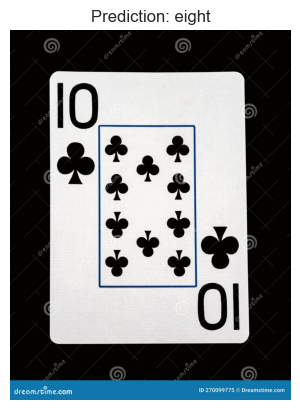

In [44]:
image_path = 'uploads/demo.jpg'
print('Displaying prediction for a sample image...')
display_prediction(resnet50_model, image_path)

### Generate Data with augmentation

#### !!! Augmentation is only applied to training data !!!

In [45]:
train_generator = data_generator(data[data['data set'] == 'train'], y_col=y_col, use_augmentation=True)
valid_generator = data_generator(data[data['data set'] == 'valid'], y_col=y_col, use_augmentation=False) # here use_augmentation is always false
test_generator = data_generator(data[data['data set'] == 'test'], y_col=y_col, use_augmentation=False) # here use_augmentation is always false

data['card type'] = data['card type'].replace('xxx', 'joker')

Found 7624 validated image filenames belonging to 14 classes.
Found 265 validated image filenames belonging to 14 classes.
Found 265 validated image filenames belonging to 14 classes.


### Custom Model v3 with Augmentation

In [46]:
model = create_custom_model_v3(**input_args, num_classes=len(train_generator.class_indices))
model = prepare_model(model, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.001,
                      metrics=['accuracy'])

history = train_model(model, train_generator, valid_generator, epochs=30, batch_size=128, use_early_stopping=True,
                      save_name="custom_model_v3_augmented", verbose=1)

Model: "custom_model_v3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 activation_13 (Activation)  (None, 109, 109, 64)      0         
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                              

In [47]:
get_classification_report(model, test_generator)

9/9 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

         ace       0.67      1.00      0.80        20
       eight       0.91      1.00      0.95        20
        five       0.85      0.85      0.85        20
        four       0.89      0.85      0.87        20
        jack       0.83      0.75      0.79        20
       joker       0.00      0.00      0.00         5
        king       0.79      0.95      0.86        20
        nine       0.94      0.80      0.86        20
       queen       0.81      0.85      0.83        20
       seven       0.94      0.85      0.89        20
         six       0.73      0.80      0.76        20
         ten       0.89      0.85      0.87        20
       three       1.00      0.90      0.95        20
         two       0.94      0.80      0.86        20

    accuracy                           0.85       265
   macro avg       0.80      0.80      0.80       265
weighted avg       0.85     

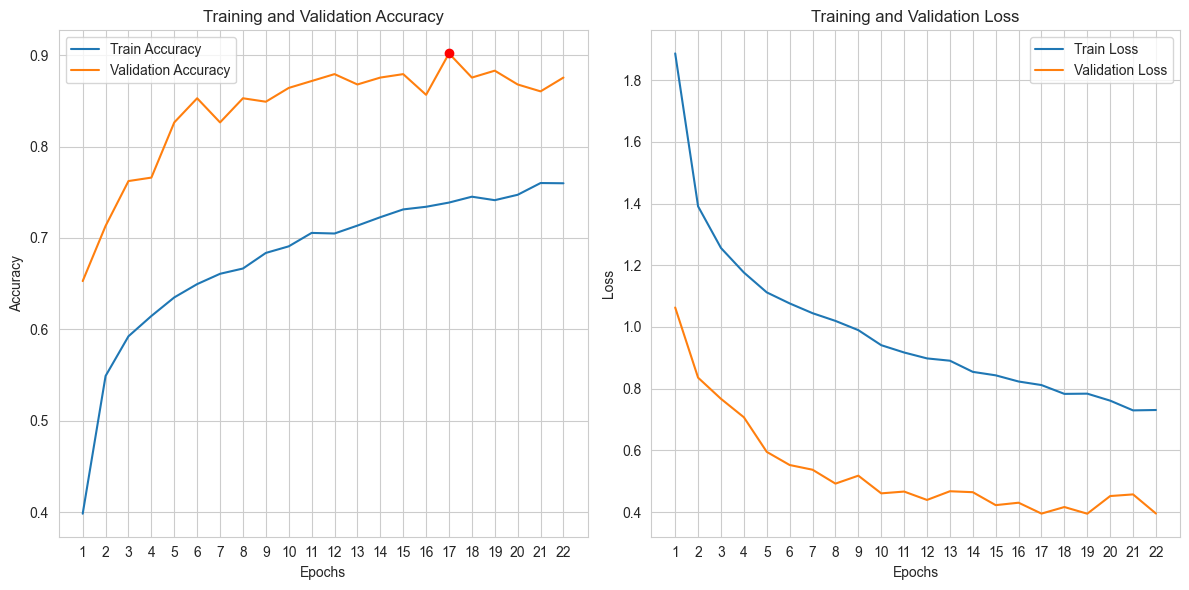

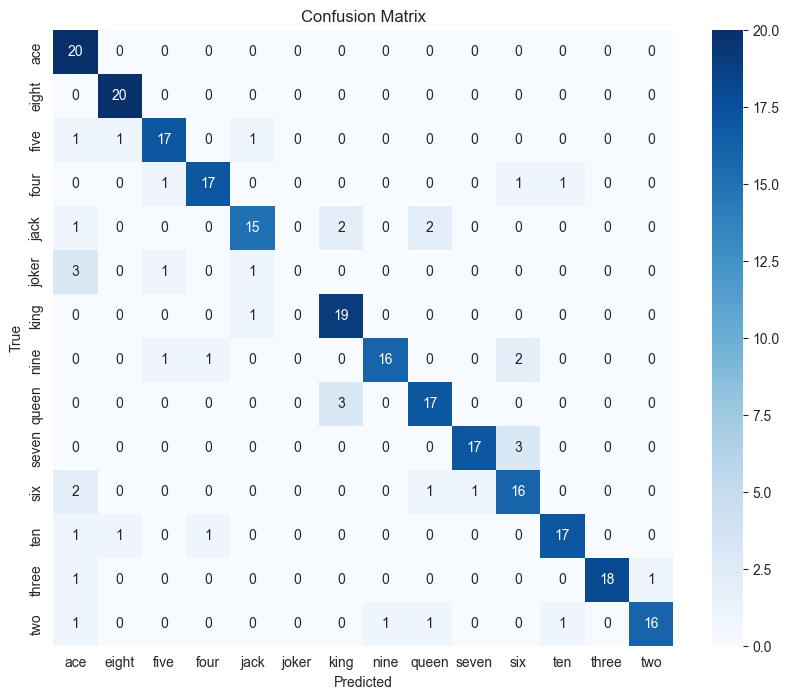

In [48]:
plot_training_history(history)
plot_confusion_matrix(model, test_generator)

In [49]:
print('Model Performance Evaluation:')
print_model_performance(model, history, valid_generator, test_generator)

Model Performance Evaluation:
Saved at Epoch: 17
Validation Loss: 0.4
Validation Accuracy: 90.19%
Test Loss: 0.56
Test Accuracy: 84.91%
Macro Recall: 80.36%
Macro F1: 79.73%


Displaying prediction for a sample image...


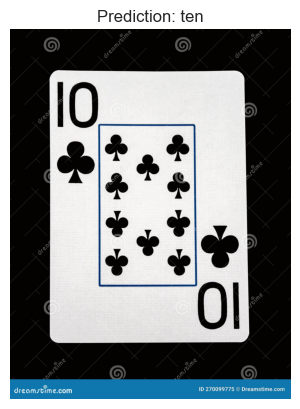

In [50]:
image_path = 'uploads/demo.jpg'
print('Displaying prediction for a sample image...')
display_prediction(model, image_path)

### VGG 19 with Augmentation

In [52]:
vgg19_model = create_pretrained_model_vgg19(shape=(224, 224, 3), num_classes=len(train_generator.class_indices))

vgg19_model = prepare_model(vgg19_model, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.0003,
                            metrics=['accuracy'])
history = train_model(vgg19_model, train_generator, valid_generator, epochs=30, batch_size=32, use_early_stopping=True,
                      save_name="vgg19_pretrained_model_augmented", verbose=1)

Model: "vgg19_pretrained_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_19 (Dense)            (None, 512)               262656    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 256)               131328    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                            

In [53]:
get_classification_report(vgg19_model, test_generator)

9/9 [==============================] - 1s 90ms/step
              precision    recall  f1-score   support

         ace       0.95      1.00      0.98        20
       eight       0.77      1.00      0.87        20
        five       0.95      0.95      0.95        20
        four       1.00      0.95      0.97        20
        jack       0.95      1.00      0.98        20
       joker       0.00      0.00      0.00         5
        king       1.00      1.00      1.00        20
        nine       1.00      0.80      0.89        20
       queen       0.77      1.00      0.87        20
       seven       1.00      1.00      1.00        20
         six       0.94      0.85      0.89        20
         ten       1.00      0.90      0.95        20
       three       0.90      0.95      0.93        20
         two       1.00      0.95      0.97        20

    accuracy                           0.93       265
   macro avg       0.87      0.88      0.87       265
weighted avg       0.92     

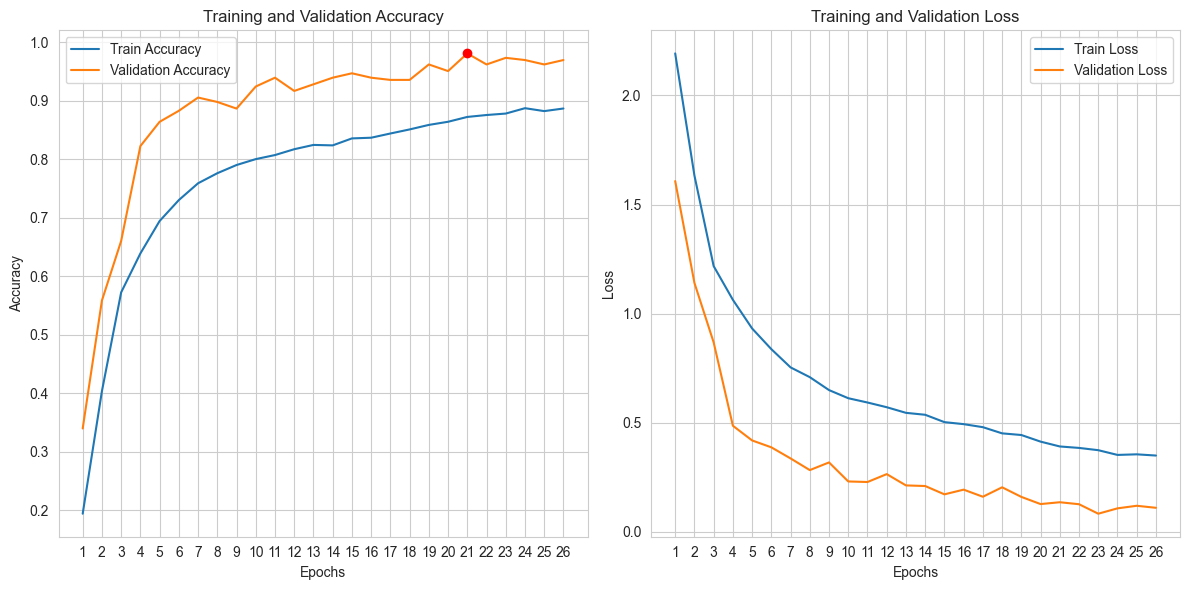

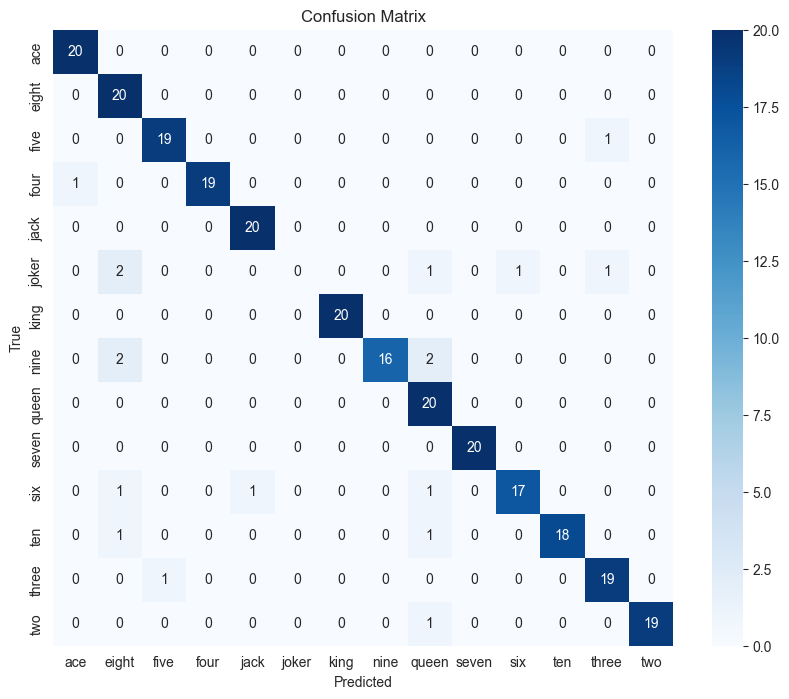

In [54]:
plot_training_history(history)
plot_confusion_matrix(vgg19_model, test_generator)

In [55]:
print('Model Performance Evaluation:')
print_model_performance(vgg19_model, history, valid_generator, test_generator)

Model Performance Evaluation:
Saved at Epoch: 21
Validation Loss: 0.14
Validation Accuracy: 98.11%
Test Loss: 0.25
Test Accuracy: 93.21%
Macro Recall: 88.21%
Macro F1: 87.48%


Displaying prediction for a sample image...


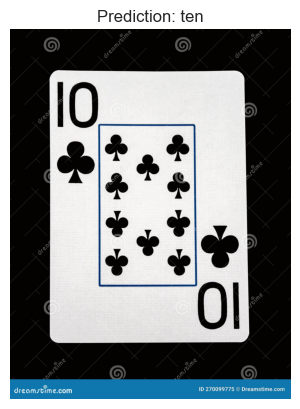

In [56]:
image_path = 'uploads/demo.jpg'
print('Displaying prediction for a sample image...')
display_prediction(vgg19_model, image_path)

### ResNet50 with Augmentation

In [57]:
resnet50_model = create_pretrained_model_resnet50(shape=(224, 224, 3), num_classes=len(train_generator.class_indices))

resnet50_model = prepare_model(resnet50_model, optimizer='adam', loss='categorical_crossentropy', learning_rate=0.0003,
                            metrics=['accuracy'])
history = train_model(resnet50_model, train_generator, valid_generator, epochs=30, batch_size=32, use_early_stopping=True,
                      save_name="resnet50_pretrained_model_augmented", verbose=1)

Model: "resnet50_pretrained_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_22 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 256)               131328    
                                                                 
 dropout_13 (Dropout)        (None, 256)               0         
                                         

In [58]:
get_classification_report(resnet50_model, test_generator)

9/9 [==============================] - 1s 55ms/step
              precision    recall  f1-score   support

         ace       0.59      1.00      0.74        20
       eight       0.63      0.95      0.76        20
        five       1.00      0.75      0.86        20
        four       0.92      0.60      0.73        20
        jack       0.34      0.50      0.41        20
       joker       0.00      0.00      0.00         5
        king       0.43      0.45      0.44        20
        nine       1.00      0.50      0.67        20
       queen       0.67      0.60      0.63        20
       seven       0.47      0.40      0.43        20
         six       0.56      0.70      0.62        20
         ten       0.93      0.70      0.80        20
       three       0.95      0.90      0.92        20
         two       0.72      0.65      0.68        20

    accuracy                           0.66       265
   macro avg       0.66      0.62      0.62       265
weighted avg       0.70     

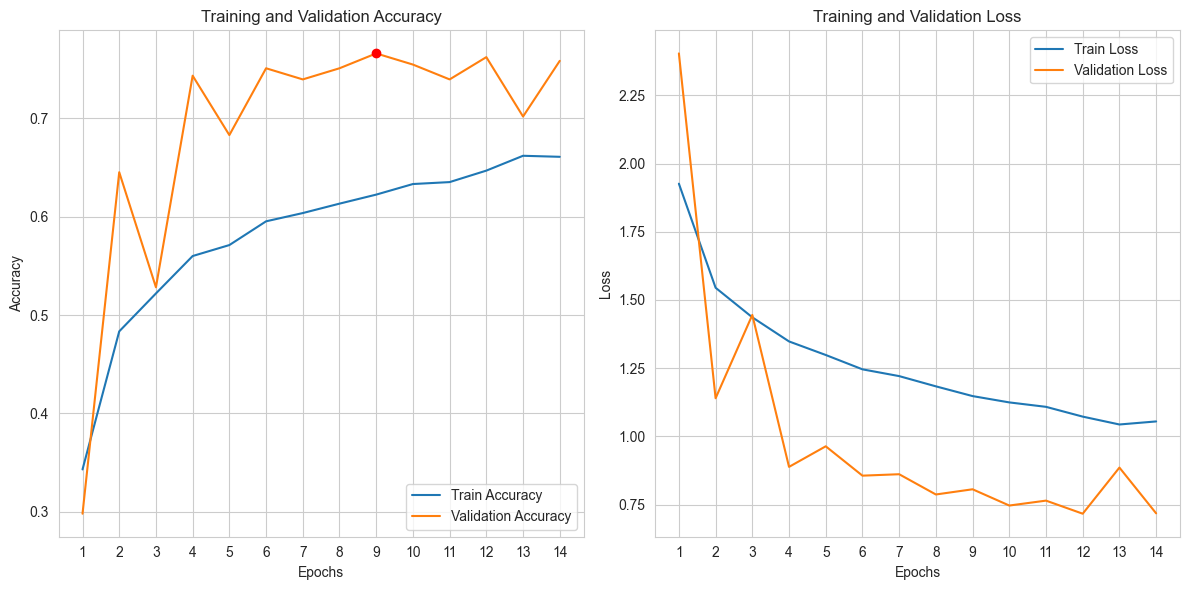

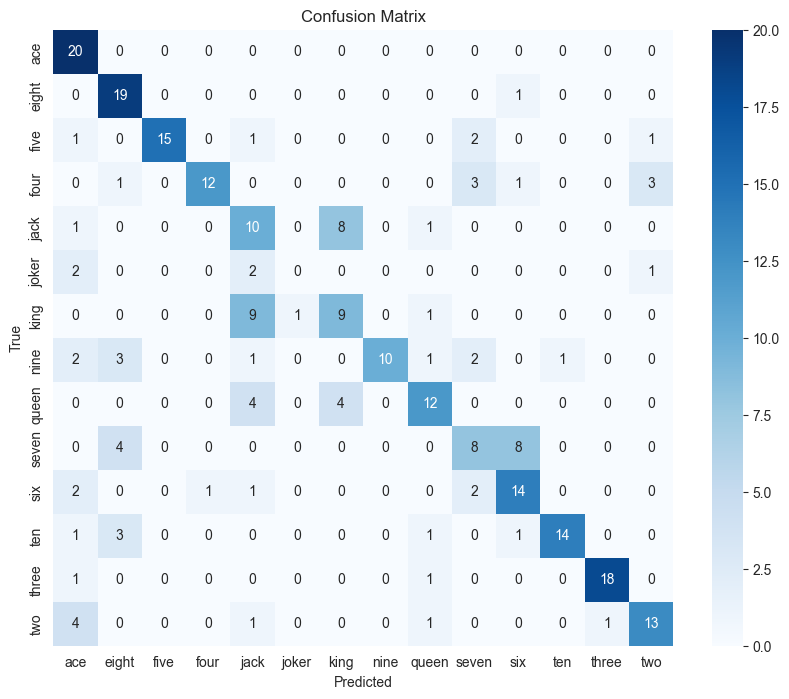

In [59]:
plot_training_history(history)
plot_confusion_matrix(resnet50_model, test_generator)

In [60]:
print('Model Performance Evaluation:')
print_model_performance(resnet50_model, history, valid_generator, test_generator)

Model Performance Evaluation:
Saved at Epoch: 9
Validation Loss: 0.81
Validation Accuracy: 76.6%
Test Loss: 1.13
Test Accuracy: 65.66%
Macro Recall: 62.14%
Macro F1: 62.09%


Displaying prediction for a sample image...


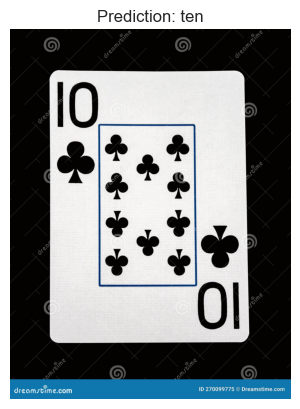

In [62]:
image_path = 'uploads/demo.jpg'
print('Displaying prediction for a sample image...')
display_prediction(resnet50_model, image_path)